In [80]:
import jax.numpy as np
import dLux as dl
import matplotlib.pyplot as plt
plt.rcParams["image.origin"] = 'lower'
import dLuxToliman as dlT
import dLux.utils as dlu
from dLuxToliman import TolimanOpticalSystem
import zodiax as zdx
from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

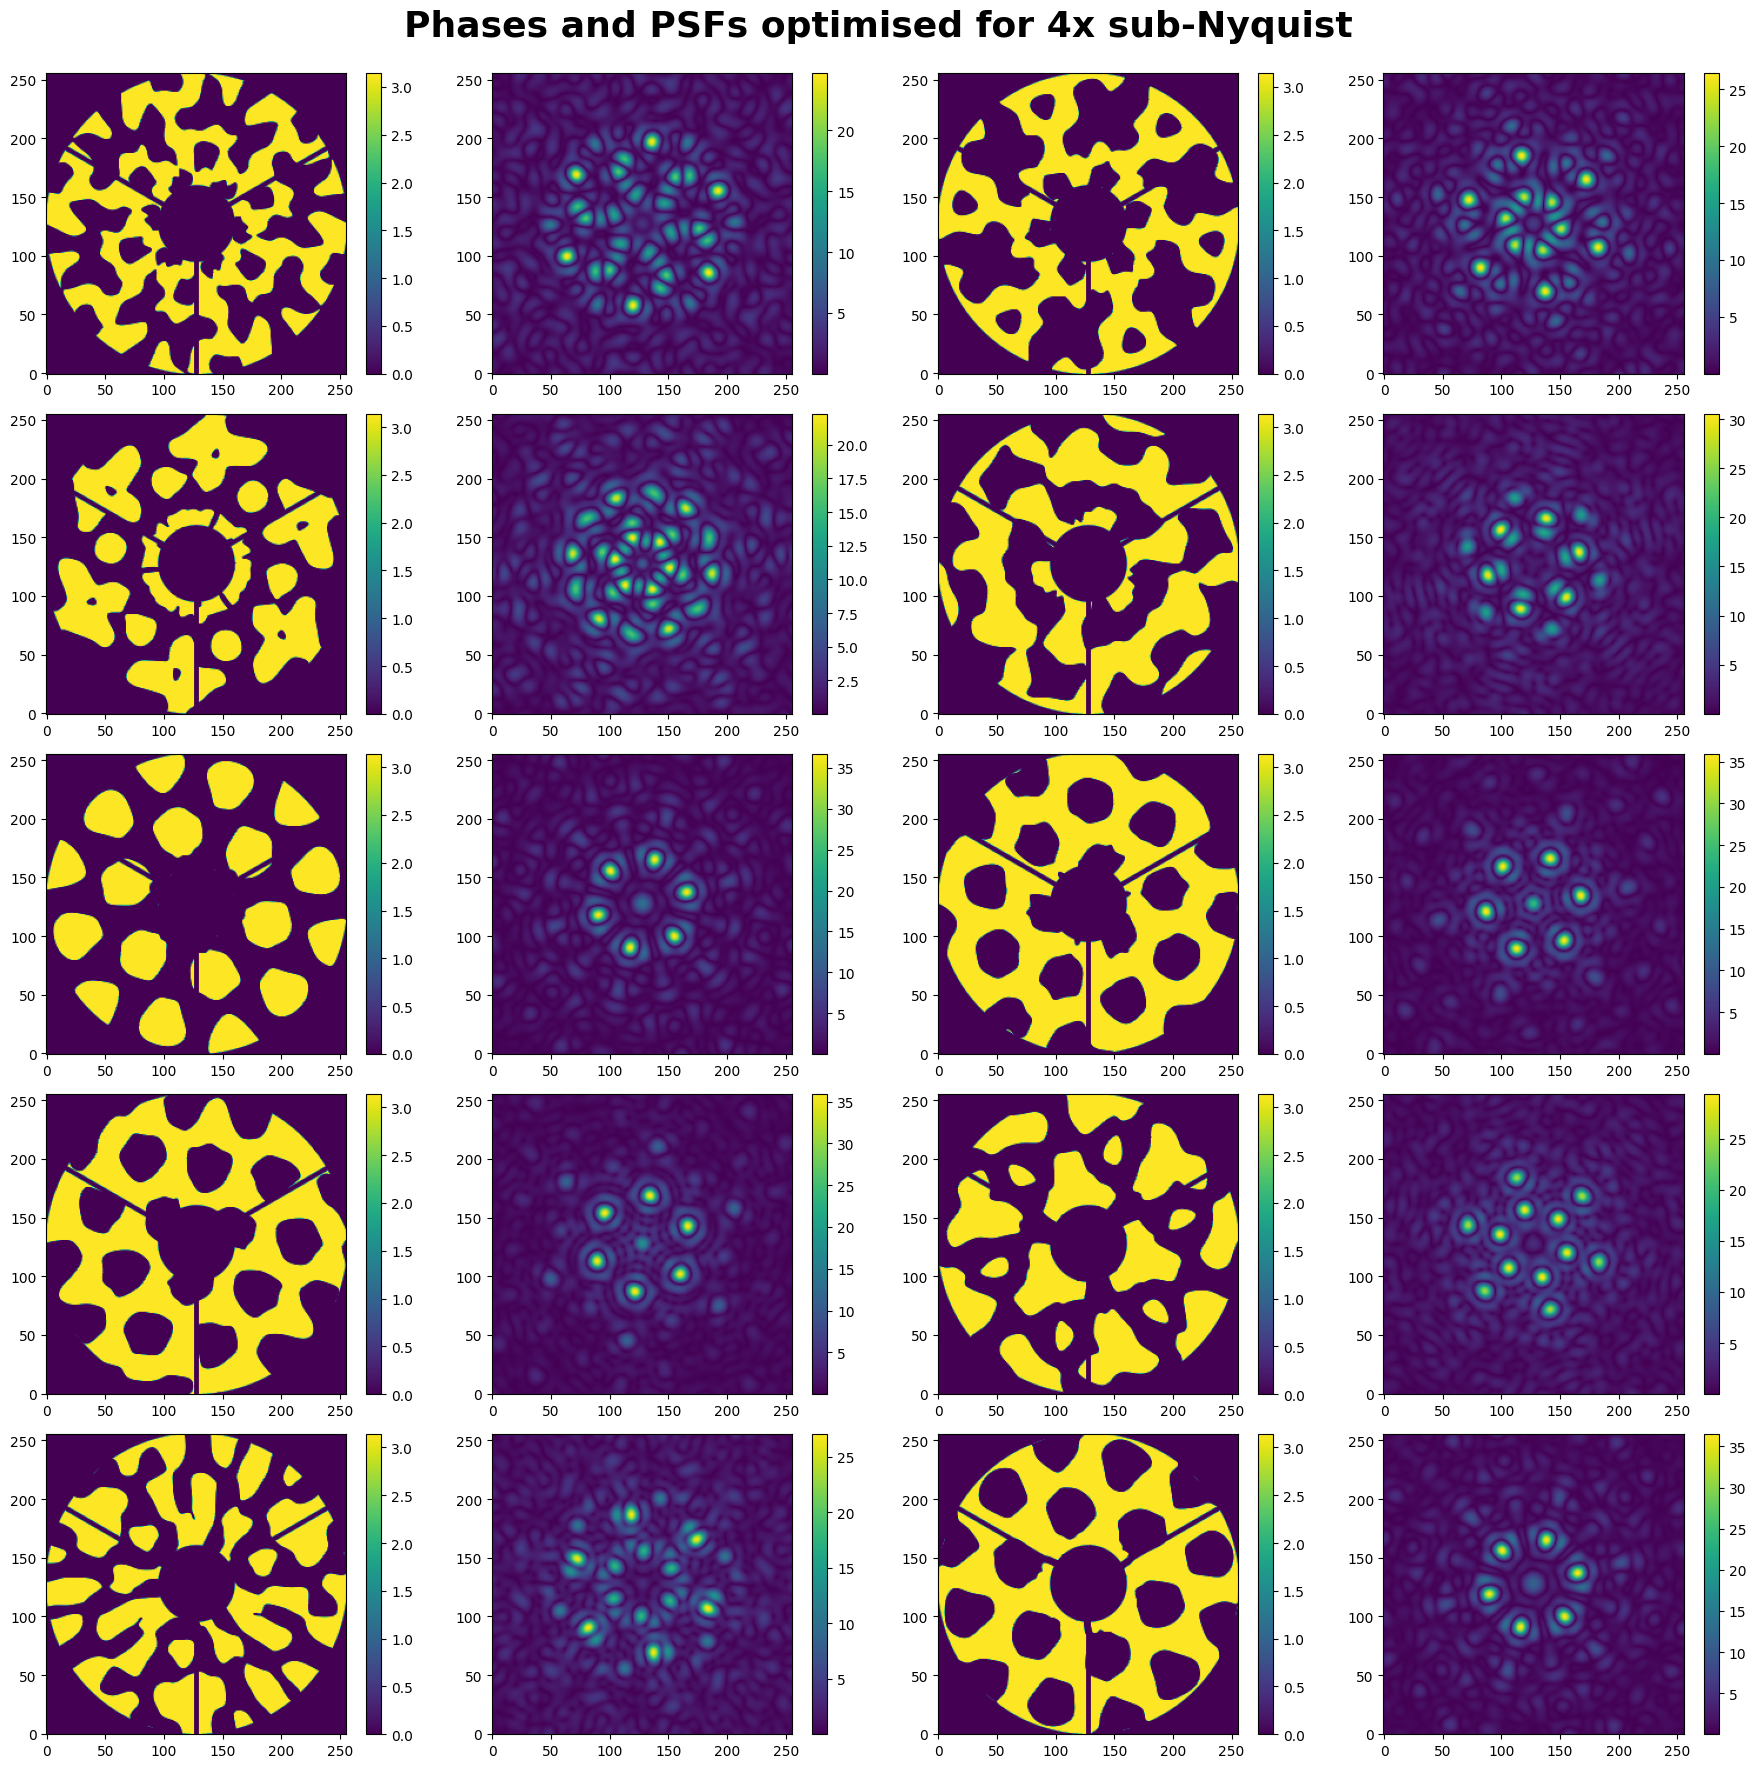

In [ ]:
plt.figure(figsize=(18,18))
plt.suptitle('Phases and PSFs optimised for 4x sub-Nyquist',fontsize=26, fontweight="bold")

for idx in np.arange(10):
    phase = np.load(f'phases/4_subsample/index_{idx}.npy')
    wf_npix = 256 

    tol_layers = [
        (
            'aperture',
            dlT.TolimanApertureLayer(wf_npix)
        ),
        (
            'pupil',
            dl.AberratedLayer(phase=phase)
        )
    ]


    diameter = 0.125 # This is default of toliman optical system. Can change.
    ### Can apply these to the input if you just want a clear aperture
    m2_diameter = 0
    strut_width = 0
    ###

    wavelength = 585e-9

    # This is to what degree we undersample Nyquist
    nyquist_factor = 0.25
    psf_npix = 64 / nyquist_factor
    psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
    oversample = nyquist_factor * 4 # sample at 4x nyquist originally

    # Place the source in the centre of the top right from center pixel.
    # That's what the position argument does here
    # dlu.arcsec2rad(np.array([psf_pixel_scale/2, psf_pixel_scale/2]))
    source = dl.PointSource(flux=1e6,position=np.array([0,0]),wavelengths=np.array([wavelength]))
    optics = dl.AngularOpticalSystem(wf_npixels=wf_npix, diameter=diameter, layers=tol_layers,psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)

    # detector layer
    detector_layers = [
        (
            'downsample',
            dl.detector_layers.Downsample(oversample)
        )
    ]

    detector = dl.LayeredDetector(layers = detector_layers)
    model = dl.Telescope(optics, source, detector)


    plt.subplot(5,4,int(2*idx+1))
    plt.imshow(model.pupil.phase*model.aperture.transmission)
    plt.colorbar()

    plt.subplot(5,4,int(2*idx+2))
    plt.imshow(model.model()**0.5)
    plt.colorbar()

plt.tight_layout(rect=[0,0,1,0.98])
#plt.savefig('4_subsample_pupils.png',bbox_inches='tight',dpi=300)
plt.show()

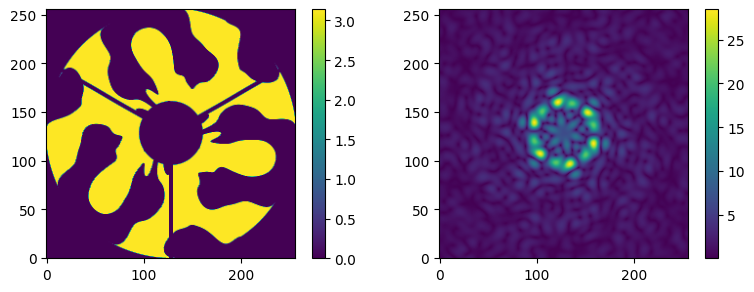

In [57]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(model.pupil.phase*model.aperture.transmission)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(model.model()**0.5)
plt.colorbar()

plt.tight_layout()
plt.show()

In [138]:
# Let us preview the fisher information of a single pupil vs diffusers etc.
# Now we need an "airy covariance" and a "diffuser/defocus covariance"
# As well as the default "Toliman" covariance.

marginal_params = 'position'
# Previewed Pupil
idx = 1
subsample = 16

# This is to what degree we undersample Nyquist
nyquist_factor = 16

phase = np.load(f'phases/{subsample}_subsample/index_{idx}.npy')
wf_npix = 256 

layers = [
    (
        'aperture',
        dlT.TolimanApertureLayer(wf_npix)
    ),
    (
        'pupil',
        dl.AberratedLayer(phase=phase)
    )
]


diameter = 0.125 # This is default of toliman optical system. Can change.
### Can apply these to the input if you just want a clear aperture
m2_diameter = 0
strut_width = 0
###

wavelength = 585e-9

psf_npix = 64 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# Place the source in the centre of the top right from center pixel.
# That's what the position argument does here
# dlu.arcsec2rad(np.array([psf_pixel_scale/2, psf_pixel_scale/2]))
source = dl.PointSource(flux=1e6,position=dlu.arcsec2rad(np.array([psf_pixel_scale/2, psf_pixel_scale/2])),wavelengths=np.array([wavelength]))
optics = dl.AngularOpticalSystem(wf_npixels=wf_npix, diameter=diameter, layers=layers,psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)

# detector layer
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(oversample)
    )
]

detector = dl.LayeredDetector(layers = detector_layers)
model = dl.Telescope(optics, source, detector)
data = model.model()
covs_fisher = zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=data)

# Tol:
optics_tol = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, psf_pixel_scale=psf_pixel_scale, oversample=oversample)
model_tol = dl.Telescope(optics_tol, source, detector)
data_tol = model_tol.model()
covs_tol = zdx.covariance_matrix(model_tol, marginal_params, poiss_loglike, data=data_tol)

# Airy:
coords = dlu.pixel_coords(wf_npix, diameter)
airy_aperture = dlu.circle(coords, 0.5*diameter)
airy_layers = [
    (
        'aperture',
        dl.TransmissiveLayer(airy_aperture,normalise=True)
    )
]
optics_airy = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=airy_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)
model_airy = dl.Telescope(optics_airy,source,detector)
data_airy = model_airy.model()
covs_airy = zdx.covariance_matrix(model_airy, marginal_params, poiss_loglike, data=data_airy)

# Zernike defocus
defocus_layers = [
    (
        'aperture',
        dlT.TolimanApertureLayer(wf_npix)
    ),
    (
        'defocus',
        dl.AberratedLayer(opd = 0.75*wavelength*dlu.zernike(4,coords,diameter))
    )
]
optics_defocus = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=defocus_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)
model_defocus = dl.Telescope(optics_defocus, source, detector)
data_defocus = model_defocus.model()
covs_defocus = zdx.covariance_matrix(model_defocus, marginal_params, poiss_loglike, data=data_defocus)


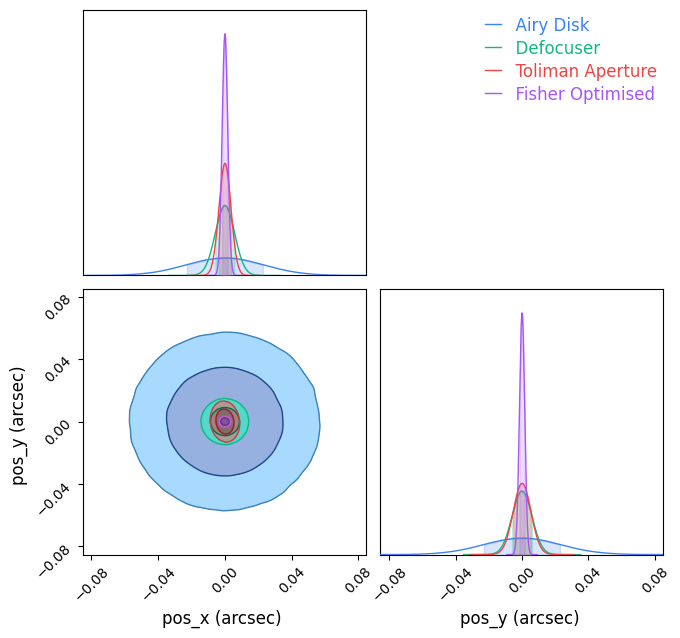

In [139]:
from chainconsumer import ChainConsumer, Chain
param_names = ["pos_x (arcsec)", "pos_y (arcsec)"]
X = np.zeros(len(param_names))

c = ChainConsumer()
# This 'commented out' one is just before optimisation
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=dlu.rad2arcsec(covs[0]), columns=param_names, name="Initial")
# )

# To convert to arcsec, have to square the conversion factor
cov_to_arcsec = dlu.rad2arcsec(1)**2
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_airy*cov_to_arcsec, columns=param_names, name="Airy Disk")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_defocus*cov_to_arcsec, columns=param_names, name='Defocuser')
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_tol*cov_to_arcsec, columns=param_names, name="Toliman Aperture")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_fisher*cov_to_arcsec, columns=param_names, name="Fisher Optimised")
)

#c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()
# Very cool/interesting results!